# Model - Spending "Lifestyles" - Clustering Document Embeddings + HDBSCAN
Coming back to the topic of sequences of credit card transactions and still using the [Sequences of purchases in credit card data reveal
life styles in urban populations](https://www.nature.com/articles/s41467-018-05690-8) paper as a reference, we will explore the patterns in the credit card transactions at a user level.

We aim at developing a "summary" of relevant spending behaviors (lifestyles) in the data. Similar to the first approach (the `lda` model), we will also use the sequences of credit card transactions as features for the model. However, in this version, we will utilize document (`user`) embedding representations for our clustering model (`hdbscan`).

In [5]:
# installing dependencies:
!pip install -r ../configs/dependencies/modeling_requirements.txt --upgrade >> ../configs/dependencies/package_installation.txt

In [1]:
# loading magic commands
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
###### Loading the necessary libraries #########

# data wrangling
import pandas as pd
import numpy as np
from tqdm import tqdm

# statistical libraries:
from scipy import stats

# plotting and visualization:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, Image

# preprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# machine learning and topic modellinng utilities
import umap
from sklearn.decomposition import PCA
import hdbscan

# other libraries:
import warnings
import logging
import joblib

# setting global parameters for visualizations:
warnings.filterwarnings("ignore")
logging.basicConfig(
    format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO
)
pd.set_option("display.precision", 4)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

<IPython.core.display.Javascript object>

# 0. Helper Functions

In [14]:
def set_plot_settings():
    """Helper function to set standard plot settings for the jupyter notebook
    Note: these are hard-coded for my specific tastes
    """
    %matplotlib inline
    %pylab inline

    plt.rcParams["figure.figsize"] = [10, 6]
    plt.rcParams["figure.dpi"] = 120
    display(HTML("<style>.container { width:100% !important; }</style>"))
    pd.set_option("display.expand_frame_repr", False)
    sns.set_style("white")


def rotate_xticks(ax, rotation):
    """Helper function to rotate x-axis labels of a matplotlib-based plot

    Args:
        ax (axes.AxesSubplot): matplotlib subplot axis object that handles the figure
        rotation (int): degrees for which to rotate the axis x-ticks

    Returns:
        None

    """
    for item in ax.get_xticklabels():
        item.set_rotation(rotation)


def get_user_vector(doc2vec_model, user_ids, user_sequences):
    """Helper function to generate doc2vec representations of user spending sequences

    Args:
        doc2vec_model ():
        user_ids (list): list containing the user ids for composing the dataframe
        user_sequences (list): list of tokenized user sequences

    Returns:
        df (pandas.DataFrame): pandas dataframe associating user_ids to their doc2vec representations
    """
    vectors = []
    for user_sequence in tqdm(user_sequences):
        vectors.append(doc2vec_model.infer_vector(user_sequence))

    df = pd.DataFrame(vectors, index=user_ids)

    return df


def plot_cluster_results(cluster_model, x, y, n_labels, palette):
    """Helper function to plot results from hdbscan clustering model

    Args:
        cluster_model (hdbscan.hdbscan_.HDBSCAN): trained hdbscan model
        x (numpy.array): array for x dimension of the embedding project
        y (numpy.array): array for y dimension of the embedding project
        n_labels (int): number of unique clusters identified

    Returns:
        None (prints to standard out)

    """

    # generating the palette:
    palette = sns.color_palette(palette, n_labels)

    # extracting the colors for each label:
    colors = [
        sns.desaturate(palette[col], sat)
        for col, sat in zip(cluster_model.labels_, cluster_model.probabilities_)
    ]

    # plotting the results:
    fig, axs = plt.subplots(figsize=(8, 6))

    plt.scatter(x, y, c=colors, alpha=0.5)

    axs.set(
        title=f"HDBSCAN results - {n_labels} clusters",
        xlabel="X-dimension",
        ylabel="Y-dimension",
    )

<IPython.core.display.Javascript object>

In [15]:
# setting the global variables for plotting:
set_plot_settings()

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>

# 1. Loading and Inspecting the Data

In [5]:
# loading the raw dataset:
PROCESSED_DATA_DIR = "../data/processed/"

# reading sequence dataset:
df_sequence = pd.read_parquet(PROCESSED_DATA_DIR + "tb_user_token_history.parquet")

<IPython.core.display.Javascript object>

In [6]:
# checking a sample of the timeline dataset:
df_sequence.sample(5)

,user_id,sequence
1592,1036,"🛒💊,🌯,🛒,🌯🎫,⛽🛒,🍽🛒,🌯,🛒🏬,⛽🛒,🍽,🍽🪑,📚🏬,💰🛒⛽,💰⛽🌯🏬,💰🏬🛒,🚕..."
815,1023,"💊,🏬⛽,🛒🏬,🛒,🛒,🛒⛽🏨,🏬,🏬💊,🛒⛽💊,🧹🏬,⛽,🏬,📚🏬👓,⛽💊,💊,🍺,🍺🏬,..."
772,89,"🌯💰💊,🌯🍽🏬,⛽,💰,📱🏬🚗,🚗,🍽🍺💰,⛽🛒👕,🛒,🌯💰🏬🚗,🍽🏬,🌯🛒🏠,🌯🔨🏬💰🛒,..."
1924,664,"💰👕🏬,🚗🏠🛒🎥,🛒,🛒🏬💈,💐🛒🍽,🚗⛽🏬🛒🎫,🍽,🛒💰🏠🧾🏬,💰👮🛒,🍽🏬,💰⛽🏬,🍽🏠..."
739,381,"🌯,🛒,🛒,🍽,🍽⛽,🚗,🍽,🍽💰🚗,⛽🏨,💰🏬,📺🏬,⛽🌯,⛽,🏬,🛒🚗,🍽,⛽,🛒,⛽🛒..."


<IPython.core.display.Javascript object>

In [7]:
# sequence dataset:
df_sequence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   2000 non-null   object
 1   sequence  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


<IPython.core.display.Javascript object>

# 2. Tokenizing Sequences of Transactions
We will start the modeling process by preparing the sequences for a bag of words representation. For each user we will generate a list of "words" he or she contains. This is done by splitting on the previously defined comma separator.

In [8]:
# generating the sentences for each user:
sequences = list(map(lambda seq: seq.split(","), df_sequence.sequence.values))

<IPython.core.display.Javascript object>

In [9]:
# verifying some of the results:
sequences[0][:10]

['🛒', '⛽🏬💊💰🛒🏠', '🏬💰', '⛽🏬', '🛒💊📱', '🏬💰🛒', '🏬⛽💰🏠', '🛒💰⛽', '🧹💰🏬', '🏬💰⛽']

<IPython.core.display.Javascript object>

In [10]:
# converting the user sequences into the Tagged Document values:
users = [TaggedDocument(user, [i]) for i, user in enumerate(sequences)]

<IPython.core.display.Javascript object>

# 3. Building Document ("User") Embeddings

In [13]:
# defining a standard dimension for the doc2vec model:
vec_size = 100

model = Doc2Vec(
    vector_size=vec_size,  # setting the size of the vector to 100 dimensions
    min_count=2,
    epochs=40,
)

<IPython.core.display.Javascript object>

In [14]:
# building the vocabulary:
model.build_vocab(users)

2021-07-11 17:37:40,473 : INFO : collecting all words and their counts
2021-07-11 17:37:40,474 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-07-11 17:37:41,537 : INFO : collected 736903 word types and 2000 unique tags from a corpus of 2000 examples and 7334513 words
2021-07-11 17:37:41,538 : INFO : Loading a fresh vocabulary
2021-07-11 17:37:42,306 : INFO : effective_min_count=2 retains 186819 unique words (25% of original 736903, drops 550084)
2021-07-11 17:37:42,306 : INFO : effective_min_count=2 leaves 6784429 word corpus (92% of original 7334513, drops 550084)
2021-07-11 17:37:42,579 : INFO : deleting the raw counts dictionary of 736903 items
2021-07-11 17:37:42,589 : INFO : sample=0.001 downsamples 41 most-common words
2021-07-11 17:37:42,589 : INFO : downsampling leaves estimated 5315910 word corpus (78.4% of prior 6784429)
2021-07-11 17:37:42,891 : INFO : estimated required memory for 186819 words and 100 dimensions: 243664700 bytes
2021-07

<IPython.core.display.Javascript object>

In [15]:
# training the model:
model.train(users, total_examples=model.corpus_count, epochs=model.epochs)

2021-07-11 17:38:45,008 : INFO : training model with 3 workers on 186819 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2021-07-11 17:38:46,016 : INFO : EPOCH 1 - PROGRESS: at 21.80% examples, 1185286 words/s, in_qsize 5, out_qsize 0
2021-07-11 17:38:47,019 : INFO : EPOCH 1 - PROGRESS: at 44.90% examples, 1193824 words/s, in_qsize 5, out_qsize 0
2021-07-11 17:38:48,020 : INFO : EPOCH 1 - PROGRESS: at 67.45% examples, 1199999 words/s, in_qsize 5, out_qsize 0
2021-07-11 17:38:49,028 : INFO : EPOCH 1 - PROGRESS: at 90.95% examples, 1200226 words/s, in_qsize 5, out_qsize 0
2021-07-11 17:38:49,452 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-11 17:38:49,453 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-11 17:38:49,456 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-11 17:38:49,457 : INFO : EPOCH - 1 : training on 7334513 raw words (5317996 effective words) took 4.4s, 1195733 

2021-07-11 17:39:28,178 : INFO : EPOCH 10 - PROGRESS: at 93.50% examples, 1237017 words/s, in_qsize 5, out_qsize 0
2021-07-11 17:39:28,451 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-11 17:39:28,452 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-11 17:39:28,456 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-11 17:39:28,457 : INFO : EPOCH - 10 : training on 7334513 raw words (5317591 effective words) took 4.3s, 1237446 effective words/s
2021-07-11 17:39:29,464 : INFO : EPOCH 11 - PROGRESS: at 23.50% examples, 1287482 words/s, in_qsize 5, out_qsize 0
2021-07-11 17:39:30,466 : INFO : EPOCH 11 - PROGRESS: at 47.60% examples, 1266036 words/s, in_qsize 6, out_qsize 0
2021-07-11 17:39:31,470 : INFO : EPOCH 11 - PROGRESS: at 70.50% examples, 1255205 words/s, in_qsize 6, out_qsize 0
2021-07-11 17:39:32,475 : INFO : EPOCH 11 - PROGRESS: at 94.75% examples, 1251946 words/s, in_qsize 5, out_qsize 0
2021-07-11 17

2021-07-11 17:40:06,402 : INFO : EPOCH - 19 : training on 7334513 raw words (5318013 effective words) took 4.1s, 1282241 effective words/s
2021-07-11 17:40:07,405 : INFO : EPOCH 20 - PROGRESS: at 23.55% examples, 1296583 words/s, in_qsize 6, out_qsize 0
2021-07-11 17:40:08,408 : INFO : EPOCH 20 - PROGRESS: at 48.35% examples, 1291302 words/s, in_qsize 5, out_qsize 0
2021-07-11 17:40:09,414 : INFO : EPOCH 20 - PROGRESS: at 72.75% examples, 1287093 words/s, in_qsize 5, out_qsize 0
2021-07-11 17:40:10,415 : INFO : EPOCH 20 - PROGRESS: at 96.30% examples, 1275599 words/s, in_qsize 5, out_qsize 0
2021-07-11 17:40:10,575 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-11 17:40:10,575 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-11 17:40:10,579 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-11 17:40:10,580 : INFO : EPOCH - 20 : training on 7334513 raw words (5318036 effective words) took 4.2s, 1273494 effecti

2021-07-11 17:40:46,618 : INFO : EPOCH 29 - PROGRESS: at 73.30% examples, 1300639 words/s, in_qsize 5, out_qsize 0
2021-07-11 17:40:47,622 : INFO : EPOCH 29 - PROGRESS: at 97.75% examples, 1295527 words/s, in_qsize 5, out_qsize 0
2021-07-11 17:40:47,708 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-11 17:40:47,709 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-11 17:40:47,713 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-11 17:40:47,713 : INFO : EPOCH - 29 : training on 7334513 raw words (5316869 effective words) took 4.1s, 1295974 effective words/s
2021-07-11 17:40:48,716 : INFO : EPOCH 30 - PROGRESS: at 23.80% examples, 1313417 words/s, in_qsize 5, out_qsize 0
2021-07-11 17:40:49,717 : INFO : EPOCH 30 - PROGRESS: at 48.65% examples, 1301213 words/s, in_qsize 5, out_qsize 0
2021-07-11 17:40:50,718 : INFO : EPOCH 30 - PROGRESS: at 73.00% examples, 1297164 words/s, in_qsize 5, out_qsize 0
2021-07-11 17

2021-07-11 17:41:24,700 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-11 17:41:24,700 : INFO : EPOCH - 38 : training on 7334513 raw words (5317578 effective words) took 4.1s, 1291770 effective words/s
2021-07-11 17:41:25,703 : INFO : EPOCH 39 - PROGRESS: at 24.60% examples, 1346997 words/s, in_qsize 5, out_qsize 0
2021-07-11 17:41:26,708 : INFO : EPOCH 39 - PROGRESS: at 49.85% examples, 1328760 words/s, in_qsize 5, out_qsize 0
2021-07-11 17:41:27,714 : INFO : EPOCH 39 - PROGRESS: at 74.25% examples, 1315706 words/s, in_qsize 5, out_qsize 0
2021-07-11 17:41:28,715 : INFO : EPOCH 39 - PROGRESS: at 98.95% examples, 1310847 words/s, in_qsize 5, out_qsize 0
2021-07-11 17:41:28,753 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-11 17:41:28,754 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-11 17:41:28,757 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-11 17:41:28,758 : INFO : EPOC

<IPython.core.display.Javascript object>

In [26]:
# let's generate the vector representations for each user:
df_users = get_user_vector(model, df_sequence.user_id.values, sequences)

100%|██████████| 2000/2000 [04:48<00:00,  6.94it/s]


<IPython.core.display.Javascript object>

In [27]:
# verifying the results:
df_users.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
1090,-11.48,9.16,8.00,-2.37,8.07,-19.63,1.14,-1.15,-4.98,1.06,...,-3.97,-7.89,-0.22,-5.49,-5.36,0.33,7.69,-7.06,-11.21,-8.75
1159,-6.21,14.42,6.36,-0.03,4.76,6.87,1.72,-2.75,-3.89,-9.00,...,-4.60,5.49,7.14,-0.79,-0.66,2.22,-2.18,-7.29,-5.07,-6.15
1436,-4.55,4.13,7.51,-3.94,2.92,-1.34,-1.84,1.74,9.55,4.07,...,8.45,-8.48,5.55,0.08,1.39,1.60,-5.73,14.22,-1.85,-5.02
1512,3.30,-6.32,-0.98,0.03,8.87,2.82,3.50,-0.88,-7.63,-3.80,...,0.81,4.68,-0.08,2.91,5.67,-3.08,10.35,-7.27,-5.03,3.55
1572,13.25,-7.47,-1.68,2.26,-0.90,-5.71,5.56,-4.40,-3.01,-2.34,...,0.96,-1.03,14.38,15.48,-1.23,-3.06,9.34,-9.21,-1.40,-8.16


<IPython.core.display.Javascript object>

In [30]:
# changing the name of the columns:
new_columns = list(map(lambda col: f"comp_{col}", df_users.columns))

# substituting the column names:
df_users.columns = new_columns

<IPython.core.display.Javascript object>

In [32]:
# reseting the index:
df_users = df_users.reset_index().rename(columns={"index": "user_id"})

<IPython.core.display.Javascript object>

In [36]:
# saving the results:
df_users.to_parquet("../data/processed/tb_user_embeddings.parquet")

<IPython.core.display.Javascript object>

# 4. Visualizing lower-dimensional representations of the Users
Now that we obtained user embeddings based on `doc2vec`, we will now apply transformations such that we can observe the document projections in a lower-dimensional space. For that, we will use a technique called `umap` (Uniform Manifold Approximation and Projection) and `pca` (Principal Component Analysis).

## 4.1 UMap representation

In [5]:
# defining the umapper with standard parameters:
umapper = umap.UMAP(random_state=42)

<IPython.core.display.Javascript object>

In [6]:
# generating the projections
embedding = umapper.fit_transform(df_users.drop(columns=["user_id"]).values)

<IPython.core.display.Javascript object>

In [7]:
# extracting the x, y paired projections:
x = embedding[:, 0]
y = embedding[:, 1]

<IPython.core.display.Javascript object>

In [11]:
# storing the results for further study:
df_user_umap = pd.DataFrame(data=embedding, index=df_users.user_id.values).reset_index()

df_user_umap.columns = ["user_id", "emb_x", "emb_y"]

df_user_umap.to_parquet("../data/processed/tb_user_umap_embeddings.parquet")

<IPython.core.display.Javascript object>

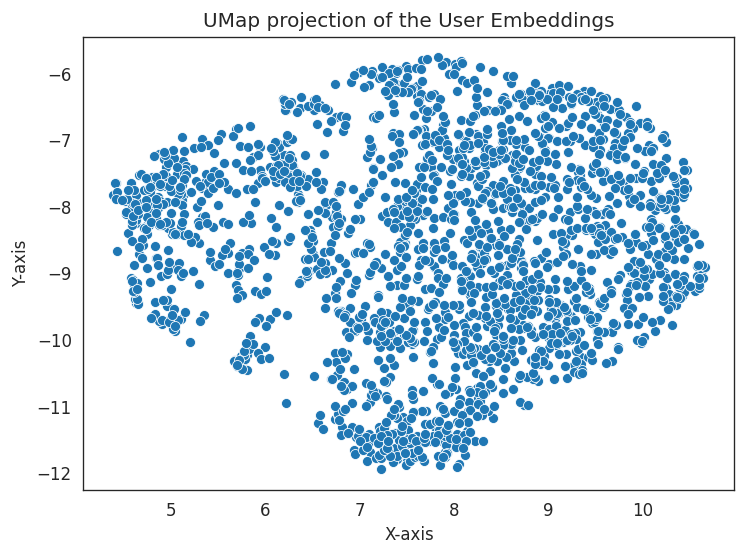

<IPython.core.display.Javascript object>

In [20]:
# plotting the data on a 2D axis:
fig, axs = plt.subplots(figsize=(7, 5))

sns.scatterplot(x=x, y=y, ax=axs)

axs.set(
    title="UMap projection of the User Embeddings", xlabel="X-axis", ylabel="Y-axis"
)

## 4.2 PCA representation

In [17]:
# defining a PCA model:
pca = PCA(n_components=2, random_state=42)

# generating the projections
pca_emb = pca.fit_transform(df_users.drop(columns=["user_id"]).values)

# extracting the components
x_pca = pca_emb[:, 0]
y_pca = pca_emb[:, 1]

<IPython.core.display.Javascript object>

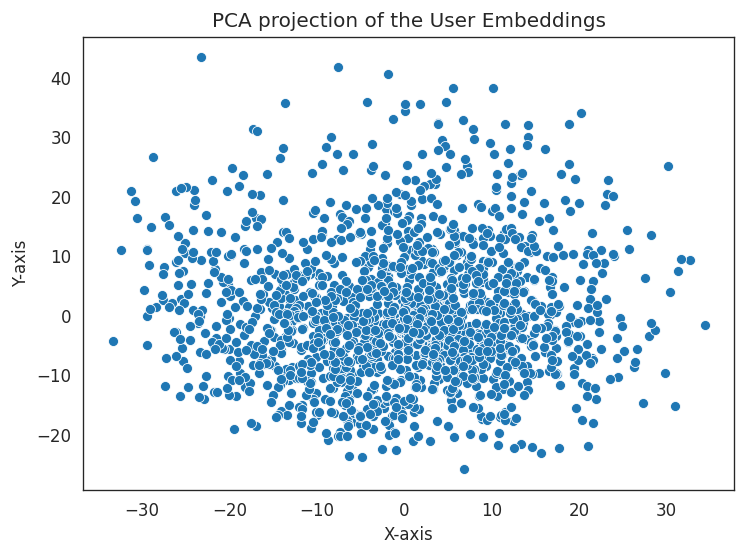

<IPython.core.display.Javascript object>

In [19]:
# plotting the data on a 2D axis:
fig, ax_pca = plt.subplots(figsize=(7, 5))

sns.scatterplot(x=x_pca, y=y_pca, ax=ax_pca)

ax_pca.set(
    title="PCA projection of the User Embeddings", xlabel="X-axis", ylabel="Y-axis"
)

When comparing both visualizations of the projections, we observe that the `umap` representation has more identifiable regions of concentration. With that, we will use this representation to cluster the users.

# 5. Clustering Users
In order to cluster th user representations, I will use a `hdbscan` (Hierarchical Density-Based Spatial Clustering of Applications with Noise). This kind of algorithm can help us avoid some common issues with algoritms that have concave decision boundaries (such as `k-means`). There are downsides, though. We can't control the number of clusters generated, only the minimum size. Similarly, there are users that have no clusters (do not belong to a high-density region), whereas in `k-means` an user will neceessarily be attributed to a cluster.

In [132]:
# defining the clustering model
cluster_model = hdbscan.HDBSCAN(min_cluster_size=150, min_samples=1)

<IPython.core.display.Javascript object>

In [133]:
# fitting the model:
cluster_model.fit(embedding)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=150, min_samples=1, p=None,
        prediction_data=False)

<IPython.core.display.Javascript object>

In [134]:
# number of clusters found:
n_clusters = len(set(cluster_model.labels_))
print(f"Number of clusters identified: {n_clusters}")

Number of clusters identified: 6


<IPython.core.display.Javascript object>

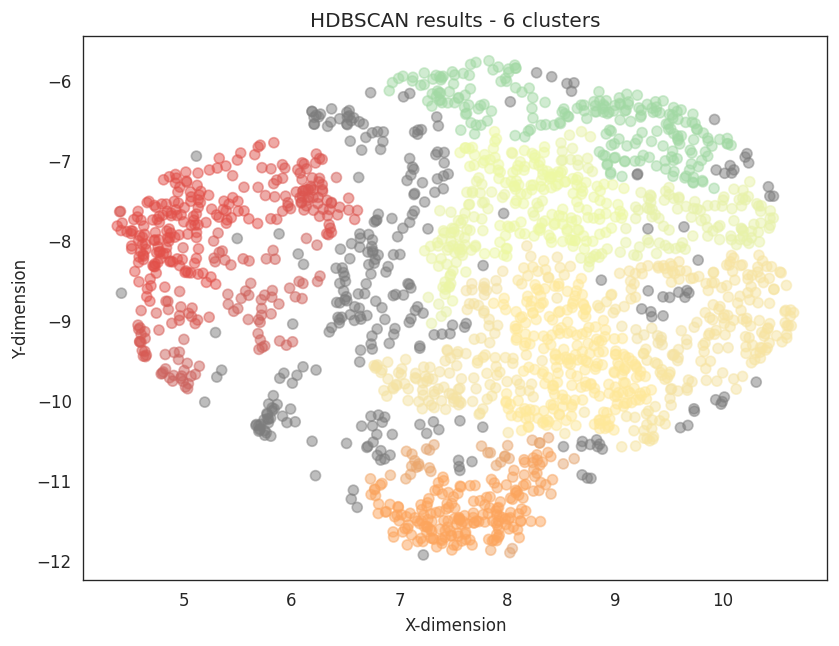

<IPython.core.display.Javascript object>

In [135]:
# plotting results:
plot_cluster_results(cluster_model, x, y, n_clusters, "Spectral")

# 6. Exporting Model Results

In [137]:
# adding cluster labels for the users:
df_output = pd.DataFrame(
    data={"user_id": df_users.user_id, "cluster": cluster_model.labels_}
)

<IPython.core.display.Javascript object>

In [139]:
# counting users per cluster:
df_output.groupby("cluster")[["user_id"]].count() # -1 indicates customers without clusters

,user_id
cluster,
-1,284
0,337
1,225
2,587
3,352
4,215


<IPython.core.display.Javascript object>

In [140]:
# exporting the results dataframe:
df_output.to_parquet("../data/predict/user_cluster_doc2vec.parquet")

<IPython.core.display.Javascript object>

In [144]:
# exporting the model file:
output_file = "../models/hdbscan/hdbscan_model.model"
joblib.dump(cluster_model, output_file)

['../models/hdbscan/hdbscan_model.model']

<IPython.core.display.Javascript object>